<a href="https://colab.research.google.com/github/Pankaj-2003/Numerai_Models/blob/main/feature_neutralization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One thing that makes predicting the stock market so hard is the "non-stationary" relationship between features and returns. Features can have strong predictive power some eras but not others - or may completely reverse over time.

This uncertainty is what we call "feature risk". In order to create models that have consistent performance, it is helpful to reduce this feature risk via "feature neutralization"

In [6]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

In [63]:
import json
import pandas as pd
from numerapi import NumerAPI

# initialize our API client
napi = NumerAPI()

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

In [61]:
napi.download_dataset(f"{DATA_VERSION}/features.json");
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
sizes = ["small", "medium", "all"]
groups = [
  "intelligence",
  "wisdom",
  "charisma",
  "dexterity",
  "strength",
  "constitution",
  "agility",
  "serenity",
  "all"
]

In [62]:
subgroups = {}
for size in sizes:
  subgroups[size] = {}
  for group in groups:
    subgroups[size][group] = (
        set(feature_sets[size]).intersection(set(feature_sets[group]))
    )
pd.DataFrame(subgroups).applymap(len).sort_values(by = "all" , ascending = False)

,small,medium,all
all,42,705,2376
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


In [65]:
# loading the "medium feature set"
medium_features = feature_sets["medium"]
# serenity feature of medium
med_serenity_feats = list(subgroups["medium"]["serenity"])

# load dataset
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")

# loading only medium features
train = pd.read_parquet(f"{DATA_VERSION}/train_int8.parquet",columns = ["era" , "target"] + medium_features)

v4.3/train_int8.parquet: 2.09GB [01:56, 18.0MB/s]                            


In [71]:
# downsampling to every fourth era
train = train[train["era"].isin(train["era"].unique()[::4])]

In [77]:
# numerai tools
!pip install -q --no-deps numerai-tools
# import numerai_corr,source code here:
# https://github.com/numerai/numerai-tools/blob/master/numerai_tools/scoring.py
from numerai_tools.scoring import numerai_corr
import numpy as np


In [113]:
per_era_corr = train.groupby("era").apply(lambda d: numerai_corr(d[med_serenity_feats] , d["target"]))

In [117]:
per_era_corr *=np.sign(per_era_corr.mean())


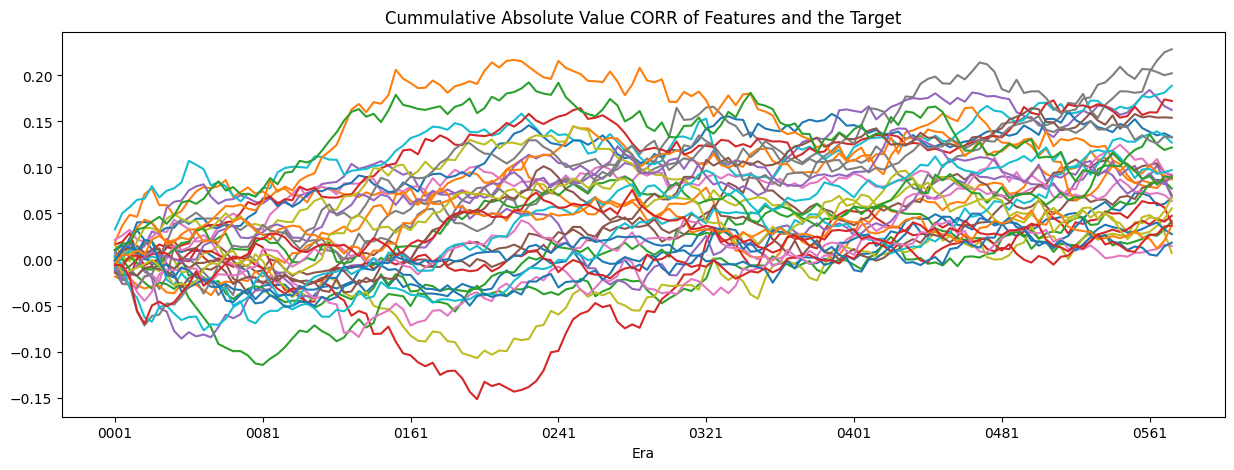

In [118]:
# plotting the per-era-correlations
per_era_corr.cumsum().plot(title = "Cummulative Absolute Value CORR of Features and the Target" , figsize = (15,5) , legend = False , xlabel = "Era");